In [46]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms 
from torchvision.utils import make_grid

import numpy as np 
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image  
import os

%matplotlib inline 

In [48]:
#build dataset class 
from torch.utils.data import Dataset


class HerderTargetDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Get position values and convert them to a float tensor
        positions = torch.tensor(self.data.iloc[idx, 1:].values.astype(float), dtype=torch.float32)

        return image, positions


In [4]:
#transforms
from torchvision import transforms 
transform = transforms.ToTensor()

dataset = HerderTargetDataset(
    csv_file='herder_target_dataset7.csv',   
    root_dir='.',           
    transform=transform
)

from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


#test
image, position = dataset[0]
print(image.shape)
print(position)


torch.Size([3, 500, 500])
tensor([ -1.6890,  17.4952,  -5.5465,   9.4755,   6.3266,  -5.3441, -10.2456,
        -13.9600,  -8.9254, -21.0192,   8.5792,  -9.3446,  21.4090, -11.8891])


In [49]:
train_loader = DataLoader(dataset, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [50]:
#grab 1 image
for i, (image, position) in enumerate(dataset):
    break

print(image.shape)

torch.Size([3, 500, 500])


In [51]:
class PositionDetector(nn.Module):
    def __init__(self):
        super(PositionDetector, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2) #2by2 kernel 
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4,4)) #per garantire che le dimensioni siano giuste
        
        # create fully connected layers (32 channels × 123 × 123 after conv/pool)
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 14)  # x, y output 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.adaptive_pool(x)  
        x = x.view(x.size(0), -1)  # Flatten out and it is -1 to vary batch size
        x = F.relu(self.fc1(x)) #fully connected layers
        x = self.fc2(x)
        return x


In [52]:
#model initialization
model = PositionDetector()

In [53]:
#Loss function & optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# Check time
import time
start_time = time.time()

# Trackers
train_losses = []
test_losses = []

# Training loop
for epoch in range(10):  # number of epochs
    model.train()
    train_loss = 0.0

    for images, positions in train_loader:
        outputs = model(images)
        loss = criterion(outputs, positions)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_losses.append(loss.item())  # track every batch loss

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}")

# Testing loop
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, positions in test_loader:
        outputs = model(images)
        loss = criterion(outputs, positions)
        test_loss += loss.item()
        test_losses.append(loss.item())  # track every batch test loss

avg_test_loss = test_loss / len(test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")

# Total time
total = time.time() - start_time
print(f"\nTraining + testing took: {total/60:.2f} minutes")


Epoch 1, Training Loss: 32.5917
Epoch 2, Training Loss: 30.0570
Epoch 3, Training Loss: 12.6390
Epoch 4, Training Loss: 7.9602
Epoch 5, Training Loss: 6.5353
Epoch 6, Training Loss: 5.6536
Epoch 7, Training Loss: 4.9496
Epoch 8, Training Loss: 4.5308
Epoch 9, Training Loss: 4.2540
Epoch 10, Training Loss: 3.9786

Test Loss: 3.7359

Training + testing took: 546.81 minutes


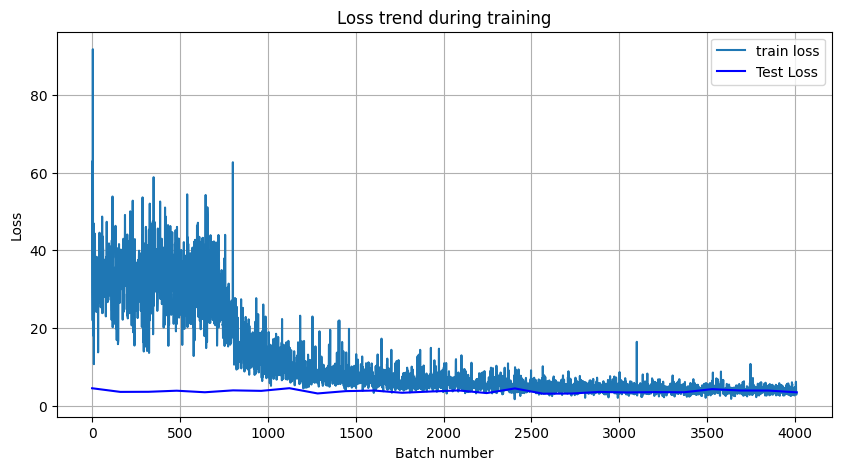

In [54]:
#accuracy evaluation 
plt.figure(figsize= (10,5))
plt.plot(train_losses, label='train loss')
plt.plot(np.linspace(0, len(train_losses), len(test_losses)), test_losses, label='Test Loss', color='blue')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title('Loss trend during training')
plt.legend()
plt.grid(True)
plt.show()


In [55]:
#inspect predictions visually
def predictions_inspection(model, dataset, index=None):
    model.eval()

    if index is None:
        import random
        index = random.randint(0, len(dataset) - 1)

    image, true_pos = dataset[index]
    true_pos = true_pos.numpy()

    with torch.no_grad():
        pred_pos = model(image.unsqueeze(0)).squeeze().numpy()

    # Image to numpy + size
    img_np = image.permute(1, 2, 0).numpy()
    img_height, img_width = img_np.shape[:2]

    plt.imshow(img_np)

    # Plot predicted coordinates (denormalized)
    for i in range(7):
        x_pred = pred_pos[i * 2]
        y_pred = pred_pos[i * 2 + 1]
        x_pixel = x_pred * img_width
        y_pixel = y_pred * img_height
        color = 'red' if i < 2 else 'blue'
        label = f"{'Herder' if i < 2 else 'Target'} {i+1 if i>=2 else i+1}"
        plt.scatter(x_pixel, y_pixel, color=color, marker='x', s=80, label=f'Pred {label}')

    # Plot real coordinates (denormalized)
    for i in range(7):
        x_true = true_pos[i * 2]
        y_true = true_pos[i * 2 + 1]
        x_pixel = x_true * img_width
        y_pixel = y_true * img_height
        color = 'green' if i < 2 else 'purple'
        label = f"{'Herder' if i < 2 else 'Target'} {i+1 if i>=2 else i+1}"
        plt.scatter(x_pixel, y_pixel, color=color, marker='o', edgecolors='black', s=80, label=f'True {label}')

    plt.title(f"Predictions vs Real coordinates #{index}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # printing coordinates (still normalized)
    print("\n Predicted coordinates (normalized):")
    for i in range(2):
        print(f"Herder {i+1}: ({pred_pos[i*2]:.2f}, {pred_pos[i*2+1]:.2f})")
    for i in range(5):
        print(f"Target {i+1}: ({pred_pos[4+i*2]:.2f}, {pred_pos[4+i*2+1]:.2f})")

    print("\n Real coordinates (normalized):")
    for i in range(2):
        print(f"Herder {i+1}: ({true_pos[i*2]:.2f}, {true_pos[i*2+1]:.2f})")
    for i in range(5):
        print(f"Target {i+1}: ({true_pos[4+i*2]:.2f}, {true_pos[4+i*2+1]:.2f})")
     

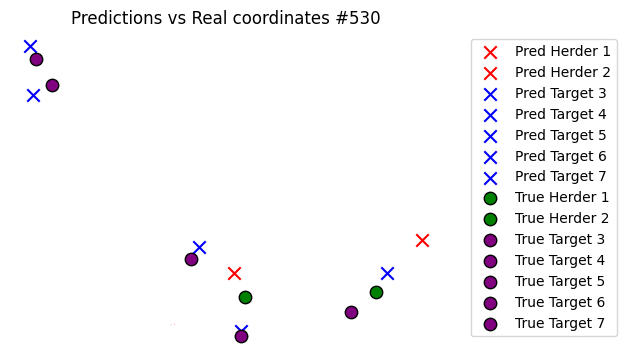


 Predicted coordinates (normalized):
Herder 1: (5.35, -3.31)
Herder 2: (19.48, -5.81)
Target 1: (5.85, 1.01)
Target 2: (-9.79, -16.74)
Target 3: (-10.03, -20.35)
Target 4: (2.72, -5.29)
Target 5: (16.78, -3.34)

 Real coordinates (normalized):
Herder 1: (6.15, -1.57)
Herder 2: (15.99, -1.94)
Target 1: (5.86, 1.36)
Target 2: (-8.32, -17.47)
Target 3: (-9.58, -19.41)
Target 4: (2.08, -4.37)
Target 5: (14.07, -0.44)


In [56]:
predictions_inspection(model, test_dataset)

In [57]:
def error_calculations(model, dataset):
    model.eval()
    errors = {f'Herder {i+1}': [] for i in range(2)}
    errors.update({f'Target {i+1}': [] for i in range(5)})

    with torch.no_grad():
        for img, true_pos in dataset:
            pred = model(img.unsqueeze(0)).squeeze().numpy()
            true = true_pos.numpy()

            # Error calculation for every agent
            for i in range(7):  # 0-1: herders, 2-6: targets
                pred_x, pred_y = pred[i*2], pred[i*2+1]
                true_x, true_y = true[i*2], true[i*2+1]
                dist = np.sqrt((pred_x - true_x)**2 + (pred_y - true_y)**2)
                label = f'Herder {i+1}' if i < 2 else f'Target {i-1}'
                errors[label].append(dist)

    print("\n Mean squared error for each agent:")
    for k, v in errors.items():
        print(f"{k}: {np.mean(v):.2f} ")

error_calculations(model, test_dataset)



 Mean squared error for each agent:
Herder 1: 3.32 
Herder 2: 2.90 
Target 1: 1.83 
Target 2: 2.07 
Target 3: 2.45 
Target 4: 1.85 
Target 5: 1.68 


In [59]:
def scatter_pred_vs_true(model, dataset):
    model.eval()
    all_pred = []
    all_true = []

    with torch.no_grad():
        for img, true_pos in dataset:
            pred = model(img.unsqueeze(0)).squeeze().numpy()
            all_pred.append(pred)
            all_true.append(true_pos.numpy())

    # Denormalizza: da [0,1] → [-30, 30]
    all_pred = np.array(all_pred) * 60 - 30
    all_true = np.array(all_true) * 60 - 30


    fig, axs = plt.subplots(7, 2, figsize=(10, 18))  # 7 agenti, x e y
    for i in range(7):
        axs[i, 0].scatter(all_true[:, i*2], all_pred[:, i*2], alpha=0.5)
        axs[i, 0].plot([min(all_true[:, i*2]), max(all_true[:, i*2])],
                       [min(all_true[:, i*2]), max(all_true[:, i*2])], 'r--')
        axs[i, 0].set_title(f'Agent {i+1} - X')

        axs[i, 1].scatter(all_true[:, i*2+1], all_pred[:, i*2+1], alpha=0.5)
        axs[i, 1].plot([min(all_true[:, i*2+1]), max(all_true[:, i*2+1])],
                       [min(all_true[:, i*2+1]), max(all_true[:, i*2+1])], 'r--')
        axs[i, 1].set_title(f'Agent {i+1} - Y')

    plt.tight_layout()
    plt.suptitle("Scatter Predetto vs Reale per ciascun agente", fontsize=16, y=1.02)
    plt.show()


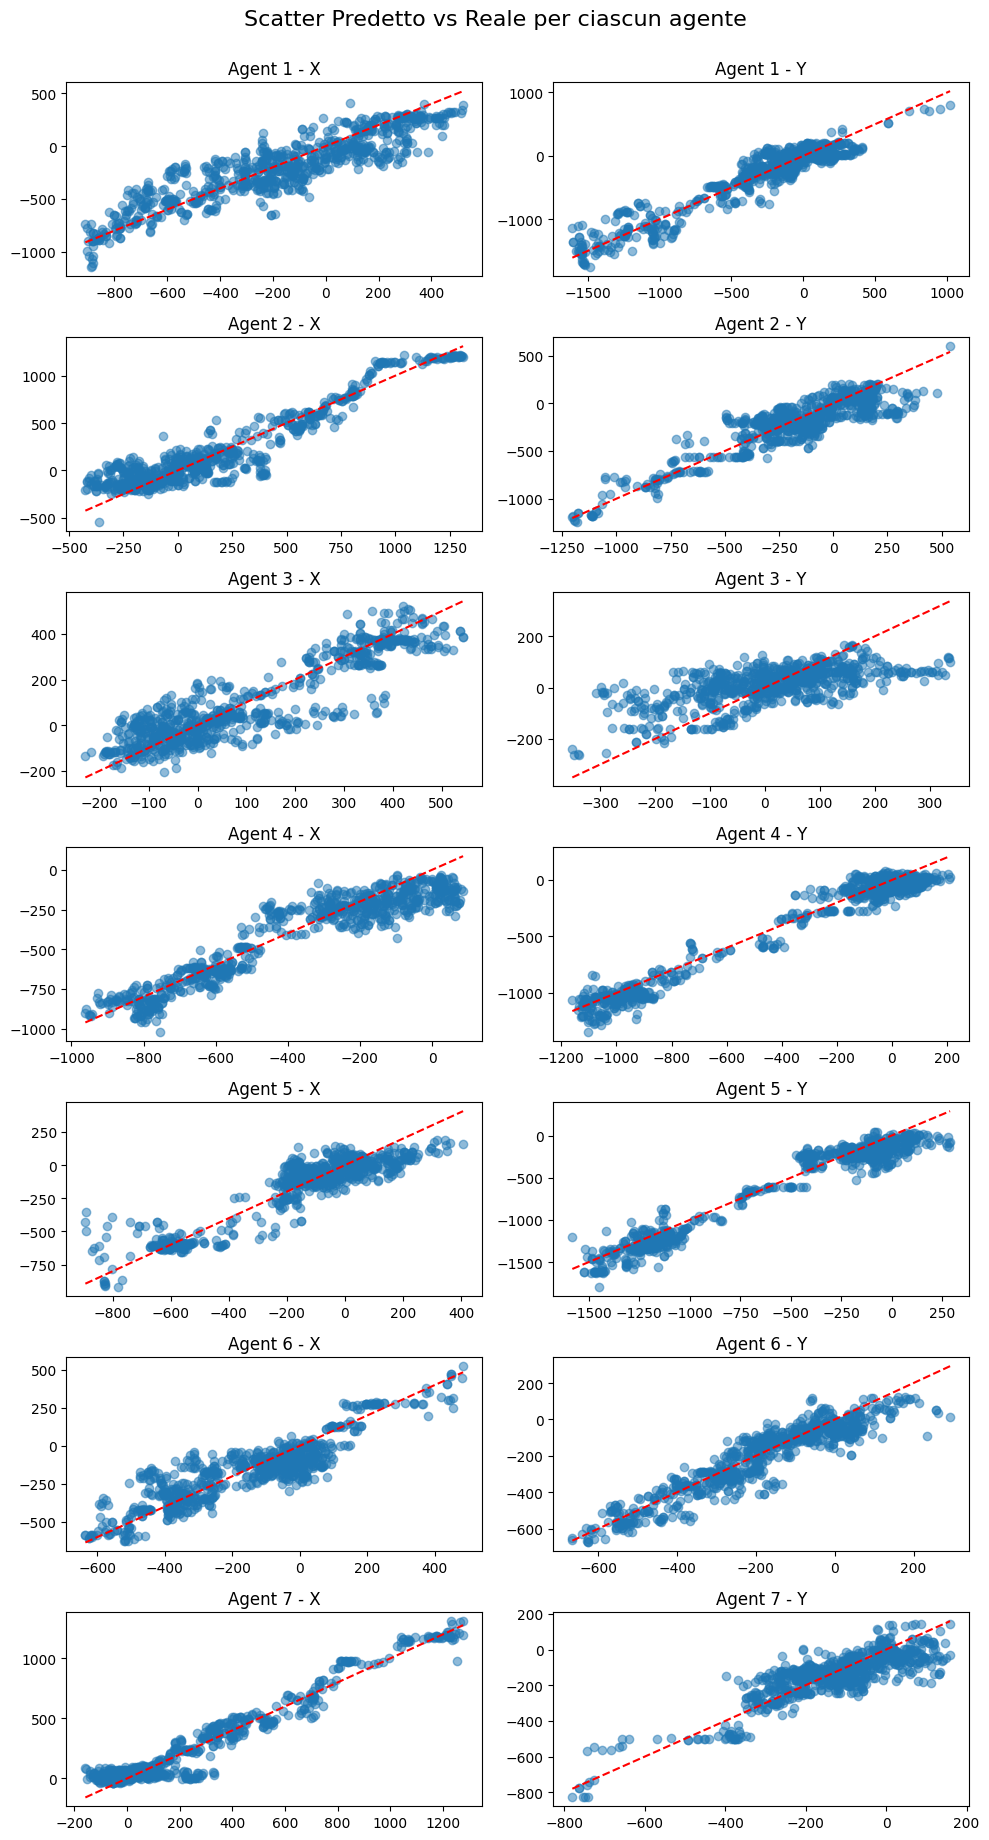

In [60]:
scatter_pred_vs_true(model, test_dataset)

In [65]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

def metriche_classificazione(model, dataset, soglia=200):
    model.eval()
    true_labels = []
    pred_labels = []
    average_precisions = []

    with torch.no_grad():
        for img, true_pos in dataset:
            pred_pos = model(img.unsqueeze(0)).squeeze().numpy()
            true_pos = true_pos.numpy()

            for i in range(7):  # 7 agenti
                x_pred, y_pred = pred_pos[i*2], pred_pos[i*2+1]
                x_true, y_true = true_pos[i*2], true_pos[i*2+1]

                # Denormalizza coordinate (in pixel o nel range reale, es. [-30, +30])
                x_pred_real = x_pred * 60 - 30
                y_pred_real = y_pred * 60 - 30
                x_true_real = x_true * 60 - 30
                y_true_real = y_true * 60 - 30

                # Distanza euclidea reale
                dist = np.sqrt((x_pred_real - x_true_real)**2 + (y_pred_real - y_true_real)**2)


                # "Classe" predetta: 1 se vicina abbastanza, altrimenti 0
                pred = 1 if dist < soglia else 0
                true = 1  # ogni oggetto è un target positivo

                pred_labels.append(pred)
                true_labels.append(true)

                # per mAP (binary relevance)
                average_precisions.append(1 - min(dist / soglia, 1))  # normalizzato tra 0 e 1

    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    mAP = np.mean(average_precisions)

    print(f"\n Metriche di classificazione con soglia {soglia} unità:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall:    {recall:.2f}")
    print(f"F1-score:  {f1:.2f}")
    print(f"mAP:       {mAP:.2f}")


In [67]:
metriche_classificazione(model, test_dataset, soglia=200)
metriche_classificazione(model, test_dataset, soglia=100)
metriche_classificazione(model, test_dataset, soglia=30)





 Metriche di classificazione con soglia 200 unità:
Precision: 1.00
Recall:    0.79
F1-score:  0.88
mAP:       0.39

 Metriche di classificazione con soglia 100 unità:
Precision: 1.00
Recall:    0.40
F1-score:  0.57
mAP:       0.16

 Metriche di classificazione con soglia 30 unità:
Precision: 1.00
Recall:    0.06
F1-score:  0.11
mAP:       0.02


In [68]:
def image_position_predictor(model, path_img, transform=transforms.ToTensor()):
    model.eval()

    # load image
    image = Image.open(path_img).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # shape: [1, 3, H, W]

    with torch.no_grad():
        prediction = model(image_tensor).squeeze().numpy()  # shape: [14]

    # display
    plt.imshow(image)
    
    # predicted coordinates plot
    # Get image size
    img_width, img_height = image.size

    # predicted coordinates plot (denormalized to pixel)
    for i in range(7):
        x_norm = prediction[i * 2]
        y_norm = prediction[i * 2 + 1]

        # denormalize to pixel space
        x_pixel = x_norm * img_width
        y_pixel = y_norm * img_height

        label = f"Herder {i+1}" if i < 2 else f"Target {i-1}"
        color = 'red' if i < 2 else 'blue'
        plt.scatter(x_pixel, y_pixel, c=color, s=60, marker='x')
        plt.text(x_pixel + 3, y_pixel + 3, label, color=color, fontsize=9)


    # print predicted coordinates
    print("\n Predicted Coordinates:")
    for i in range(2):
        print(f"Herder {i+1}: ({prediction[i*2]:.2f}, {prediction[i*2+1]:.2f})")
    for i in range(5):
        idx = 4 + i * 2
        print(f"Target {i+1}: ({prediction[idx]:.2f}, {prediction[idx+1]:.2f})")



 Predicted Coordinates:
Herder 1: (-0.90, 12.81)
Herder 2: (-2.33, 2.28)
Target 1: (5.95, -3.89)
Target 2: (-10.39, -14.31)
Target 3: (-10.39, -21.60)
Target 4: (8.34, -10.43)
Target 5: (22.24, -13.21)


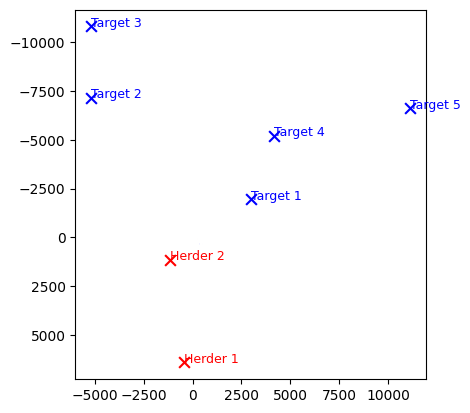

In [69]:
image_position_predictor(model, "frames7/frame_00012.png")
